## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_agent = pd.read_csv('assessment_data/AGENT.csv')
df_main = pd.read_csv('assessment_data/MAIN.csv')
df_b = pd.read_csv('assessment_data/B.csv')
df_c = pd.read_csv('assessment_data/C.csv')  
df_d = pd.read_csv('assessment_data/D.csv')
df_e = pd.read_csv('assessment_data/E.csv')

Since we are only interested in  the Inforceagents under the agency distribution channel. We will filter the agent data first

In [3]:
print(len(df_agent))
df_agent = df_agent[(df_agent['AGT_CHANNEL'] == 'AGENCY') & (df_agent['AGT_STATUS'] == 'INFORCE')]
print(len(df_agent))
agent_code_list = df_agent['AGT_CD'].unique().tolist()

4812
3231


In [4]:
#filter out the agents that are inforce and have channel as AGENCY
print(len(df_main))
df_main = df_main[df_main['AGT_CD'].isin(agent_code_list)]
print(len(df_main))

598269
495854


Here I Assume LAT == LA Takaful , then we replace the value for joining the table to main

In [5]:
df_b['CHAR_VALUE2'] = np.where(df_b['CHAR_VALUE2'] == 'LA TAKAFUL','LAT', df_b['CHAR_VALUE2'])
df_d['CHAR_VALUE2'] = np.where(df_d['CHAR_VALUE2'] == 'LA TAKAFUL','LAT', df_d['CHAR_VALUE2'])

In [6]:
#rename the column to left join
df_main = df_main.rename(columns = {'PRODUCT_CD':'PURPOSE_CODE'})
df_main_b = pd.merge(df_main, df_b[['CHAR_VALUE','CHAR_VALUE2','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE','S_BASE'], right_on=['PURPOSE_CODE','CHAR_VALUE2'])
df_main_b = df_main_b.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_B',
                                        'CHAR_VALUE2':'CHAR_VALUE2_B'})
#take the one is null
df_main_c = pd.merge(df_main_b, df_c[['CHAR_VALUE','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE'], right_on=['PURPOSE_CODE'])
df_main_c = df_main_c.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_C'})
df_main_d = pd.merge(df_main_c, df_d[['CHAR_VALUE','CHAR_VALUE2','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE','S_BASE'], right_on=['PURPOSE_CODE','CHAR_VALUE2'])
df_main_d = df_main_d.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_D',
                                        'CHAR_VALUE2':'CHAR_VALUE2_D'})
df_main_e = pd.merge(df_main_d, df_e[['CHAR_VALUE','PURPOSE_CODE']], how='left', left_on=['PURPOSE_CODE'], right_on=['PURPOSE_CODE'])
df_main_e = df_main_e.rename(columns = {'CHAR_VALUE':'CHAR_VALUE_E'})

In [7]:
df = df_main_e

In [8]:
#Get the main need from the main_need sql logic
df['MAIN_NEED'] = np.where(df['S_BASE'] == 'POLA', 'Accident',
                                np.where(df['CHAR_VALUE_D'].notna(), df['CHAR_VALUE_D'].str.strip(), #D
                                         np.where(df['CHAR_VALUE_E'].notna(), df['CHAR_VALUE_E'].str.strip(), #E
                                                  np.where((df['CHAR_VALUE_B'].notna()) & (df['CHAR_VALUE_B']!='Medical'), df['CHAR_VALUE_B'].str.strip(), #B
                                                           np.where((df['CHAR_VALUE_B'].notna()) & (df['CHAR_VALUE_B']=='Medical'), 'Other Medical', #B
                                                                    np.where((df['CHAR_VALUE_C'].notna()) & (df['CHAR_VALUE_C']!='Medical'), df['CHAR_VALUE_C'].str.strip(), #C
                                                                             np.where((df['CHAR_VALUE_C'].notna()) & (df['CHAR_VALUE_C']=='Medical'), 'Other Medical', None))))))) #C

In [9]:
#Fill PROD_CAT based on the product_category sql logic
df['PROD_CAT'] = np.where(df['PROD_CAT'].notna(),
                               df['PROD_CAT'], 
                               np.where((df['PROD_SUBCAT_IND_1'] == 1) & ((df['PROD_SUBCAT_IND_2'] == 1) | df['MAIN_NEED'].isin(['Medical','Other Medical','Critical Illness'])),
                                        'Cat 2',
                                        'Cat 3'))
df['PROD_CAT'].value_counts()

PROD_CAT
Cat 3    360331
Cat 2    123756
Cat 1     11767
Name: count, dtype: int64

In [10]:
df = df.drop(columns = ['CHAR_VALUE_B',
                                  'CHAR_VALUE_C',
                                  'CHAR_VALUE_D',
                                  'CHAR_VALUE_E',
                                  'CHAR_VALUE2_B',
                                  'CHAR_VALUE2_D'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495854 entries, 0 to 495853
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   POLICY_NO          495854 non-null  int64  
 1   AGT_CD             495854 non-null  int64  
 2   S_BASE             495854 non-null  object 
 3   RIDER_CD           479533 non-null  float64
 4   COVERAGE_TYPE_IND  495854 non-null  object 
 5   INS_UNIQUE_ID      495854 non-null  object 
 6   PURCHASE_DT        495854 non-null  object 
 7   PROD_CAT           495854 non-null  object 
 8   PURPOSE_CODE       495854 non-null  object 
 9   ANP_RIDER          495854 non-null  float64
 10  VIT_MBR_IND        495854 non-null  int64  
 11  PROD_SUBCAT_IND_1  495854 non-null  int64  
 12  PROD_SUBCAT_IND_2  495854 non-null  int64  
 13  MAIN_NEED          495854 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 53.0+ MB


## EDA

Questions To be Asked Regarding Data

1. Does All Rider will have the same portfolio with the basic policy.
2. Does Purchase Date of the same policy are the same or it can be different (rider for other date)
3. What does ANP meaning
4. Does Every Agent has their own specific Portfolio or they can sell any of it
5. Does ANP only for certain_product
6. Distribution of date purchase of each agent

In [20]:
df['POLICY_NO'].nunique()

125059

In [53]:
#Get the overall timeline of the data
print(df['PURCHASE_DT'].min(), df['PURCHASE_DT'].max())

2019-01-01 2030-07-31


There are error in the data as it shows year of 2030

In [55]:
#Lets check if there are policy has different date with the basic policy
policy_date = df.groupby(['POLICY_NO']).agg({'PURCHASE_DT' : 'unique'})
multiple_datee = policy_date[policy_date['PURCHASE_DT'].apply(len) > 1]
print(multiple_datee)

                                    PURCHASE_DT
POLICY_NO                                      
191        [2019-06-27, 2020-08-27, 2020-06-27]
270                    [2020-07-26, 2021-02-26]
597                    [2019-06-24, 2021-02-24]
700                    [2020-02-22, 2019-11-22]
889                    [2020-05-22, 2019-11-22]
...                                         ...
516504                 [2020-05-15, 2019-05-15]
519794                 [2019-11-07, 2020-05-07]
525845                 [2020-06-30, 2019-06-30]
542538                 [2020-04-23, 2019-04-23]
555525                 [2019-07-31, 2020-07-31]

[980 rows x 1 columns]


It means Rider can be bought in a different time from the basic policy

In [66]:
df['PURCHASE_DT'] = pd.to_datetime(df['PURCHASE_DT'])
df[df['PURCHASE_DT'].dt.year >2025]

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
141557,47644,102,LA,10300.0,R,P005020208,2030-07-31,Cat 3,RGT1,0.0,0,1,0,Savers
310350,201604,1448,LA,10300.0,R,P000562216,2030-07-06,Cat 3,RGT1,0.0,1,1,0,Savers
310515,309404,1448,LA,10300.0,R,P004507014,2030-07-29,Cat 3,RGT1,0.0,1,1,0,Savers
358968,143909,1515,LA,10300.0,R,P004768393,2030-06-22,Cat 3,RGT1,0.0,1,1,0,Savers
358991,201589,1515,LA,10300.0,R,P000975859,2030-06-01,Cat 3,RGT1,0.0,1,1,0,Savers
477473,89979,3524,LA,10300.0,R,P001349387,2030-06-14,Cat 3,RGT1,0.0,1,1,0,Savers


In [69]:
df[df['PURPOSE_CODE']=='RGT1']

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
141557,47644,102,LA,10300.0,R,P005020208,2030-07-31,Cat 3,RGT1,0.0,0,1,0,Savers
310350,201604,1448,LA,10300.0,R,P000562216,2030-07-06,Cat 3,RGT1,0.0,1,1,0,Savers
310515,309404,1448,LA,10300.0,R,P004507014,2030-07-29,Cat 3,RGT1,0.0,1,1,0,Savers
358968,143909,1515,LA,10300.0,R,P004768393,2030-06-22,Cat 3,RGT1,0.0,1,1,0,Savers
358991,201589,1515,LA,10300.0,R,P000975859,2030-06-01,Cat 3,RGT1,0.0,1,1,0,Savers
477473,89979,3524,LA,10300.0,R,P001349387,2030-06-14,Cat 3,RGT1,0.0,1,1,0,Savers


The PURPOSE CODE RGT1 is where all of the policy has error in the purchase date. Since there are many possibilities whether its a has the same date as the basic policy or different we will just drop these data.

In [70]:
df = df[df['PURCHASE_DT'].dt.year <=2025]

In [72]:
print(df['PURCHASE_DT'].min(), df['PURCHASE_DT'].max())

2019-01-01 00:00:00 2025-03-10 00:00:00


S_BASE
LA      74894
LAT     33844
POLA    16321
Name: count, dtype: int64

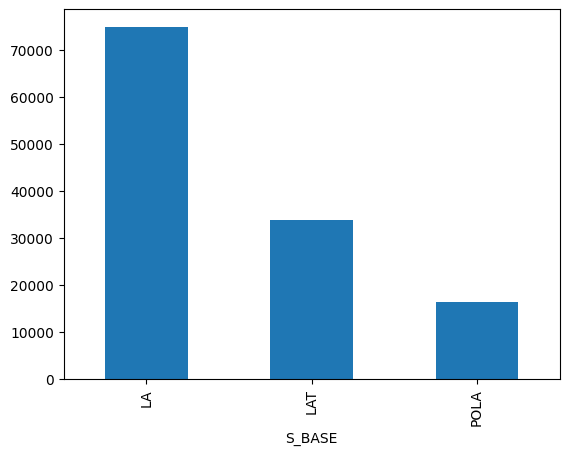

In [22]:
#get the distribution of the portfolio
df.groupby(['POLICY_NO'])['S_BASE'].first().value_counts().plot(kind='bar')
df.groupby(['POLICY_NO'])['S_BASE'].first().value_counts()

In [24]:
370809/125045

2.9654044543964173

The number are making sense , since multiple riders can be with basic policy and the Ratio are almost 3:1 For Every Basic Policy there might be 3 Rider

In [86]:
#do agent can sell different portfolio
df.groupby(['AGT_CD']).agg({'S_BASE': 'unique'})

,S_BASE
AGT_CD,
1,[LA]
2,[LA]
3,"[LA, LAT]"
4,[LA]
5,[LAT]
...,...
4806,[LA]
4807,[POLA]
4808,[LA]


yes agent can sell different product from different portfolio

In [94]:
# Does ANP is just for a certain product?
prod_code_anp = df[df['ANP_RIDER']>0]['PURPOSE_CODE'].unique().tolist()
df[(df['PURPOSE_CODE'].isin(prod_code_anp)) & (df['ANP_RIDER'] == 0)]

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
109,3,1186,LAT,10200.0,R,P004313476,2019-10-24,Cat 3,1EH7,0.0,1,1,0,Savers
272,31179,1186,LAT,10200.0,R,P010394341,2020-01-06,Cat 3,1EH8,0.0,1,1,0,Savers
300,38099,1186,LAT,10200.0,R,P001779270,2019-10-28,Cat 3,2EH8,0.0,0,1,0,Savers
414,111868,1186,LAT,10200.0,R,P010192534,2020-05-05,Cat 3,APSV,0.0,1,1,0,Savers
866,114371,3642,LA,10200.0,R,P000257359,2019-03-28,Cat 3,18ET,0.0,1,1,0,Savers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491553,190573,1756,LA,10106.0,R,P010798070,2021-01-05,Cat 3,RCC2,0.0,0,0,0,Accident
491565,243772,1756,LA,10106.0,R,P002306805,2020-11-11,Cat 3,RCC2,0.0,0,0,0,Accident
491613,399400,1756,LA,10106.0,R,P005117395,2020-12-18,Cat 3,RCC2,0.0,0,0,0,Accident
492989,256483,4755,LA,10104.0,R,P010760186,2020-12-04,Cat 3,RCC2,0.0,0,0,0,Accident


Nope the same Product code does not mean they have ANP.

PROD_CAT
Cat 1     11765
Cat 2     61438
Cat 3    101787
Name: POLICY_NO, dtype: int64

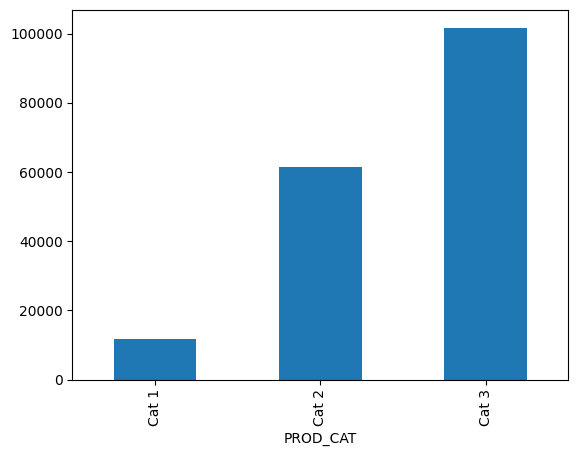

In [28]:
# Question 1
# What is the total number of policies sold by product categories?
df.groupby(['PROD_CAT'])['POLICY_NO'].nunique().plot(kind='bar')
df.groupby(['PROD_CAT'])['POLICY_NO'].nunique()

<Axes: ylabel='Frequency'>

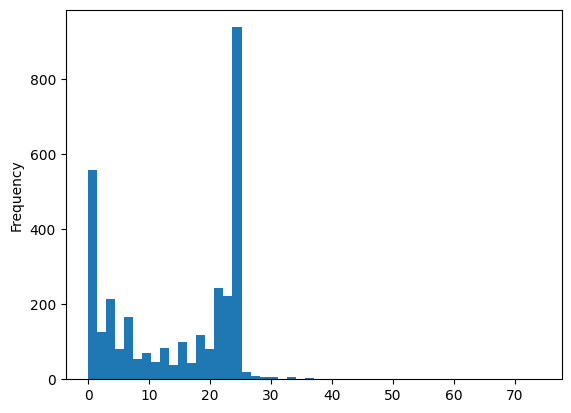

In [105]:
# Agent Distribution on Notice Served
date_df = df.groupby(['AGT_CD']).agg(
    PURCHASE_DT_MIN=('PURCHASE_DT', 'min'),
    PURCHASE_DT_MAX=('PURCHASE_DT', 'max')
)
date_df['MONTHS_DIFF'] = (
    (date_df['PURCHASE_DT_MAX'].dt.year - date_df['PURCHASE_DT_MIN'].dt.year) * 12 + 
    (date_df['PURCHASE_DT_MAX'].dt.month - date_df['PURCHASE_DT_MIN'].dt.month)
)
date_df['MONTHS_DIFF'].plot(kind='hist',bins=50)

Quite A lot of number are in the early stage and the mod is around 2 years+

<Axes: xlabel='LAST_YEAR'>

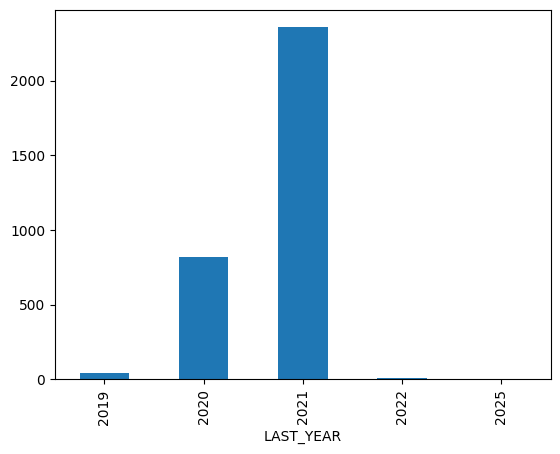

In [110]:
date_df['LAST_YEAR'] = date_df['PURCHASE_DT_MAX'].dt.year
date_df['LAST_YEAR'].value_counts().sort_index().plot(kind='bar')

Quite a lot of agent has a final selling date at 2021, meaning we cannot approach a very time sensitive approach.

PROD_CAT
Cat 1    10232935.06
Cat 2     5610835.00
Cat 3    24963325.87
Name: ANP_RIDER, dtype: float64

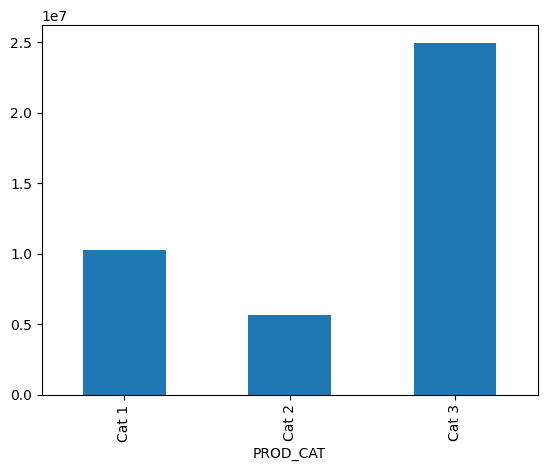

In [29]:
# Question 1
# What is the total ANP by categories?
df.groupby(['PROD_CAT'])['ANP_RIDER'].sum().plot(kind='bar')
df.groupby(['PROD_CAT'])['ANP_RIDER'].sum() 

In [41]:
# Question 3
#Number of agents who sold at least 5 Vitality attached policy.
agent_vit_group = df.groupby(['AGT_CD']).agg({'VIT_MBR_IND' : 'count'})
agent_vit_group[agent_vit_group['VIT_MBR_IND'] >= 5]

,VIT_MBR_IND
AGT_CD,
1,286
2,9
3,107
4,699
5,216
...,...
4792,5
4793,19
4794,6


In [45]:
#Question 4
#Number of policies with at least 3 riders attached.
# Filter only Rider Policy
df_rider = df[df['COVERAGE_TYPE_IND'] == 'R']
df_rider_group = df_rider.groupby(['POLICY_NO']).agg({'RIDER_CD' : 'count'})
df_rider_group[df_rider_group['RIDER_CD'] >= 3]

,RIDER_CD
POLICY_NO,
1,10
3,3
8,3
9,6
11,3
...,...
555571,3
556808,4
565910,3


## Data Transformation

In [11]:
#Possible Feature for agent persona (agent behaviour)

## Overall
#1 . Number of basic policies sold per agent
#2 . Median/Average number of riders per basic policy


## Tendency of Portfolio
#3 . Ratio of LA/S_BASE
#4 . Ratio of LAT/S_BASE
#5 . Ratio of POLA/S_BASE

## Tendency of Main Need
#6 . Ratio Medical/MAIN_NEED
#7 . Ratio Life/MAIN_NEED
#8 . Ratio Disability/MAIN_NEED
#9 . Ratio Savers/MAIN_NEED
#10 . Ratio Payor_Waiver/MAIN_NEED
#11 . Ratio Critical_Illness/MAIN_NEED
#12 . Ratio Accident/MAIN_NEED
#13. Ratio Income/MAIN_NEED
#14 . Ratio Other_Medical/MAIN_NEED
#15 . Ratio Endowment/MAIN_NEED

#Time Sensitive Features
#16 . Median/Average number of policies sold per month 
#17 . Variance of number of policies sold per month
#17 . Last Month/Last Year of purchase ## Not Using since we are looking at the agent persona throughout the years
#19 . Duration of First Purchase to Last Purchase (Served Duration as Agent)

In [12]:
df

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
0,1,3640,LAT,10102.0,R,P001664420,2020-03-26,Cat 2,ACC0,0.00,0,1,0,Critical Illness
1,1,3640,LAT,10103.0,R,P001664420,2020-03-26,Cat 2,AHI0,0.00,0,1,1,Income
2,1,3640,LAT,10108.0,R,P001664420,2020-03-26,Cat 3,VIT1,0.00,0,1,0,Life
3,1,3640,LAT,10200.0,R,P001664420,2020-03-26,Cat 3,ART0,120.00,0,1,0,Savers
4,1,3640,LAT,10107.0,R,P001664420,2020-03-26,Cat 3,ART2,0.00,0,1,0,Accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495849,551619,4212,LA,10100.0,B,P010373499,2019-09-13,Cat 2,MER1,88.30,0,1,0,Medical
495850,583668,4212,LA,10100.0,B,P002828561,2020-08-05,Cat 2,MER2,117.80,0,1,0,Medical
495851,583668,4212,LA,10101.0,R,P002828561,2020-08-05,Cat 2,APH1,29.60,0,1,0,Medical
495852,589062,3073,LA,10100.0,B,P010685096,2020-09-22,Cat 2,MER2,103.46,0,1,0,Medical


In [13]:
#Number of basic policies sold per agent
agent_group_basic = df.groupby(['AGT_CD']).agg({
'POLICY_NO': pd.Series.nunique})
agent_group_basic = agent_group_basic .rename(columns = {'POLICY_NO':'n_basic_policy'})
agent_group_basic

,n_basic_policy
AGT_CD,
1,56
2,5
3,45
4,146
5,61
...,...
4806,1
4807,1
4808,1


In [14]:
#Median/Average number of riders per basic policy
riders_per_policy = df[df['COVERAGE_TYPE_IND'] == 'R'].groupby(['AGT_CD','POLICY_NO']).agg({
'COVERAGE_TYPE_IND':'count'})
riders_per_policy.rename(columns={'COVERAGE_TYPE_IND': 'RIDER_COUNT'}, inplace=True)
avg_riders_per_agent = riders_per_policy.groupby('AGT_CD')['RIDER_COUNT'].mean().reset_index()
avg_riders_per_agent.rename(columns={'RIDER_COUNT': 'AVG_RIDERS_PER_POLICY'}, inplace=True)
avg_riders_per_agent

,AGT_CD,AVG_RIDERS_PER_POLICY
0,1,4.339623
1,2,1.000000
2,3,1.512195
3,4,3.787671
4,5,3.039216
...,...,...
3102,4794,5.000000
3103,4796,2.000000
3104,4801,1.500000
3105,4804,1.000000


In [15]:
#get each agent portfolio ratio
portfolio_ratio = pd.crosstab(df['AGT_CD'], df['S_BASE'], normalize='index').add_prefix('RATIO_').add_suffix('_'+'S_BASE')
portfolio_ratio

S_BASE,RATIO_LA_S_BASE,RATIO_LAT_S_BASE,RATIO_POLA_S_BASE
AGT_CD,,,
1,1.000000,0.000000,0.0
2,1.000000,0.000000,0.0
3,0.364486,0.635514,0.0
4,1.000000,0.000000,0.0
5,0.000000,1.000000,0.0
...,...,...,...
4806,1.000000,0.000000,0.0
4807,0.000000,0.000000,1.0
4808,1.000000,0.000000,0.0


In [16]:
#get each agent MAIN_NEED ratio
main_need_ratio = pd.crosstab(df['AGT_CD'], df['MAIN_NEED'], normalize='index')
main_need_ratio.columns = ['RATIO_' + col.upper().replace(' ','_') + '_MAIN_NEED' for col in main_need_ratio.columns]
main_need_ratio

,RATIO_ACCIDENT_MAIN_NEED,RATIO_CRITICAL_ILLNESS_MAIN_NEED,RATIO_DISABILITY_MAIN_NEED,RATIO_ENDOWMENT_MAIN_NEED,RATIO_INCOME_MAIN_NEED,RATIO_LIFE_MAIN_NEED,RATIO_MEDICAL_MAIN_NEED,RATIO_OTHER_MEDICAL_MAIN_NEED,RATIO_PAYOR/WAIVER_MAIN_NEED,RATIO_SAVERS_MAIN_NEED
AGT_CD,,,,,,,,,,
1,0.000000,0.153846,0.174825,0.010490,0.000000,0.167832,0.129371,0.038462,0.143357,0.181818
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.000000,0.009346,0.233645,0.009346,0.000000,0.233645,0.355140,0.018692,0.093458,0.046729
4,0.072961,0.024320,0.184549,0.015737,0.017167,0.168813,0.175966,0.001431,0.173104,0.165951
5,0.009259,0.157407,0.236111,0.000000,0.013889,0.319444,0.120370,0.000000,0.106481,0.037037
...,...,...,...,...,...,...,...,...,...,...
4806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4807,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [ ]:
#16 . Median/Average number of policies sold per month
#17 . Variance number of policies sold per month
df['PURCHASE_DT'] = pd.to_datetime(df['PURCHASE_DT']) 
monthly_sales = df.groupby(['AGT_CD', df['PURCHASE_DT'].dt.to_period('M')]).agg({'POLICY_NO': 'count'}).reset_index().sort_values(['AGT_CD', 'PURCHASE_DT']) # get monh-year count polcy sold for each agent
agent_date_range = df.groupby('AGT_CD')['PURCHASE_DT'].agg(['min', 'max']) # get min and max date for each agent
monthly_sales.columns = ['AGT_CD', 'month', 'policies_sold']

#Fill in the missing months
def create_complete_monthly_series(agent_data):
    agent_cd = agent_data['AGT_CD'].iloc[0]
    start_date = agent_date_range.loc[agent_cd, 'min']
    end_date = agent_date_range.loc[agent_cd, 'max']
    
    complete_months = pd.period_range(
        start=start_date.to_period('M'), 
        end=end_date.to_period('M'), 
        freq='M'
    )
    
    complete_df = pd.DataFrame({
        'AGT_CD': agent_cd,
        'month': complete_months,
        'policies_sold': 0  # Default 0
    })
    
    for _, row in agent_data.iterrows():
        complete_df.loc[complete_df['month'] == row['month'], 'policies_sold'] = row['policies_sold']
    
    return complete_df

complete_monthly_data = []
for agent_cd in monthly_sales['AGT_CD'].unique():
    agent_data = monthly_sales[monthly_sales['AGT_CD'] == agent_cd]
    complete_data = create_complete_monthly_series(agent_data)
    complete_monthly_data.append(complete_data)

complete_monthly_df = pd.concat(complete_monthly_data, ignore_index=True)
agent_stats_complete = complete_monthly_df.groupby('AGT_CD')['policies_sold'].agg([
    'mean', 'median', 'var', 'std'
]).round(3)

agent_stats_complete.columns = ['monthly_avg_sold', 'monthly_median_sold', 
                               'monthly_var_sold', 'monthly_std_sold']
agent_stats_complete

,monthly_avg_sold,monthly_median_sold,monthly_var_sold,monthly_std_sold
AGT_CD,,,,
1,11.440,11.0,116.423,10.790
2,1.800,2.0,4.200,2.049
3,7.133,5.0,35.981,5.998
4,43.688,23.0,2128.229,46.133
5,9.391,6.0,106.522,10.321
...,...,...,...,...
4806,2.000,2.0,NaN,NaN
4807,1.000,1.0,NaN,NaN
4808,1.000,1.0,NaN,NaN


In [18]:
#19 . Duration of First Purchase to Last Purchase (Served Duration as Agent)
agent_tenure = df.groupby('AGT_CD')['PURCHASE_DT'].agg(['min', 'max']).reset_index()
agent_tenure.columns = ['AGT_CD', 'first_purchase', 'last_purchase']

date_col = ['first_purchase', 'last_purchase']

# for col in date_col:
#     agent_tenure[col] = pd.to_datetime(agent_tenure[col])

agent_tenure['tenure_days'] = (agent_tenure['last_purchase'] - agent_tenure['first_purchase']).dt.days
agent_tenure['tenure_years'] = agent_tenure['tenure_days'] / 365.25  # Account for leap years

# Handle agents with only one transaction (tenure = 1)
agent_tenure['tenure_years'] = agent_tenure['tenure_years'].fillna(0).round(10)
agent_tenure

,AGT_CD,first_purchase,last_purchase,tenure_days,tenure_years
0,1,2019-01-02,2021-01-11,740,2.026010
1,2,2020-06-07,2020-10-06,121,0.331280
2,3,2019-10-31,2020-12-06,402,1.100616
3,4,2019-11-24,2021-02-28,462,1.264887
4,5,2019-04-29,2021-02-03,646,1.768652
...,...,...,...,...,...
3226,4806,2019-05-22,2019-05-22,0,0.000000
3227,4807,2019-07-01,2019-07-01,0,0.000000
3228,4808,2020-08-05,2020-08-05,0,0.000000
3229,4809,2021-02-26,2021-02-26,0,0.000000


In [43]:
df_train = pd.merge(agent_group_basic,avg_riders_per_agent, how='left', on='AGT_CD')
df_train = pd.merge(df_train, portfolio_ratio, how='left', on='AGT_CD')
df_train = pd.merge(df_train, main_need_ratio, how='left', on='AGT_CD')
df_train = pd.merge(df_train, agent_stats_complete[['monthly_median_sold','monthly_std_sold']], how='left', on='AGT_CD')
df_train = pd.merge(df_train, agent_tenure[['AGT_CD','tenure_years']], how='left', on='AGT_CD')
df_train

,AGT_CD,n_basic_policy,AVG_RIDERS_PER_POLICY,RATIO_LA_S_BASE,RATIO_LAT_S_BASE,RATIO_POLA_S_BASE,RATIO_ACCIDENT_MAIN_NEED,RATIO_CRITICAL_ILLNESS_MAIN_NEED,RATIO_DISABILITY_MAIN_NEED,RATIO_ENDOWMENT_MAIN_NEED,RATIO_INCOME_MAIN_NEED,RATIO_LIFE_MAIN_NEED,RATIO_MEDICAL_MAIN_NEED,RATIO_OTHER_MEDICAL_MAIN_NEED,RATIO_PAYOR/WAIVER_MAIN_NEED,RATIO_SAVERS_MAIN_NEED,monthly_median_sold,monthly_std_sold,tenure_years
0,1,56,4.339623,1.000000,0.000000,0.0,0.000000,0.153846,0.174825,0.010490,0.000000,0.167832,0.129371,0.038462,0.143357,0.181818,11.0,10.790,2.026010
1,2,5,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.0,2.049,0.331280
2,3,45,1.512195,0.364486,0.635514,0.0,0.000000,0.009346,0.233645,0.009346,0.000000,0.233645,0.355140,0.018692,0.093458,0.046729,5.0,5.998,1.100616
3,4,146,3.787671,1.000000,0.000000,0.0,0.072961,0.024320,0.184549,0.015737,0.017167,0.168813,0.175966,0.001431,0.173104,0.165951,23.0,46.133,1.264887
4,5,61,3.039216,0.000000,1.000000,0.0,0.009259,0.157407,0.236111,0.000000,0.013889,0.319444,0.120370,0.000000,0.106481,0.037037,6.0,10.321,1.768652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,4806,1,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.0,NaN,0.000000
3227,4807,1,NaN,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000
3228,4808,1,NaN,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000
3229,4809,1,NaN,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000


In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGT_CD                            3231 non-null   int64  
 1   n_basic_policy                    3231 non-null   int64  
 2   AVG_RIDERS_PER_POLICY             3107 non-null   float64
 3   RATIO_LA_S_BASE                   3231 non-null   float64
 4   RATIO_LAT_S_BASE                  3231 non-null   float64
 5   RATIO_POLA_S_BASE                 3231 non-null   float64
 6   RATIO_ACCIDENT_MAIN_NEED          3231 non-null   float64
 7   RATIO_CRITICAL_ILLNESS_MAIN_NEED  3231 non-null   float64
 8   RATIO_DISABILITY_MAIN_NEED        3231 non-null   float64
 9   RATIO_ENDOWMENT_MAIN_NEED         3231 non-null   float64
 10  RATIO_INCOME_MAIN_NEED            3231 non-null   float64
 11  RATIO_LIFE_MAIN_NEED              3231 non-null   float64
 12  RATIO_

In [45]:
df_train[df_train['monthly_std_sold'].isna()]

,AGT_CD,n_basic_policy,AVG_RIDERS_PER_POLICY,RATIO_LA_S_BASE,RATIO_LAT_S_BASE,RATIO_POLA_S_BASE,RATIO_ACCIDENT_MAIN_NEED,RATIO_CRITICAL_ILLNESS_MAIN_NEED,RATIO_DISABILITY_MAIN_NEED,RATIO_ENDOWMENT_MAIN_NEED,RATIO_INCOME_MAIN_NEED,RATIO_LIFE_MAIN_NEED,RATIO_MEDICAL_MAIN_NEED,RATIO_OTHER_MEDICAL_MAIN_NEED,RATIO_PAYOR/WAIVER_MAIN_NEED,RATIO_SAVERS_MAIN_NEED,monthly_median_sold,monthly_std_sold,tenure_years
60,87,1,6.000000,1.0,0.0,0.0,0.0,0.000000,0.142857,0.0,0.142857,0.142857,0.142857,0.000000,0.142857,0.285714,7.0,NaN,0.000000
68,98,2,2.000000,0.0,1.0,0.0,0.0,0.000000,0.250000,0.0,0.000000,0.250000,0.250000,0.000000,0.250000,0.000000,4.0,NaN,0.000000
81,112,9,2.333333,0.0,1.0,0.0,0.0,0.043478,0.260870,0.0,0.000000,0.304348,0.173913,0.043478,0.130435,0.043478,23.0,NaN,0.010951
94,125,4,6.750000,0.0,1.0,0.0,0.0,0.129032,0.129032,0.0,0.000000,0.290323,0.096774,0.096774,0.129032,0.129032,31.0,NaN,0.021903
103,136,1,NaN,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,4806,1,1.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.0,NaN,0.000000
3227,4807,1,NaN,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000
3228,4808,1,NaN,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000
3229,4809,1,NaN,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,NaN,0.000000


In [46]:
df[df['AGT_CD']==467]

,POLICY_NO,AGT_CD,S_BASE,RIDER_CD,COVERAGE_TYPE_IND,INS_UNIQUE_ID,PURCHASE_DT,PROD_CAT,PURPOSE_CODE,ANP_RIDER,VIT_MBR_IND,PROD_SUBCAT_IND_1,PROD_SUBCAT_IND_2,MAIN_NEED
478383,99308,467,LAT,10100.0,B,P005411616,2021-02-17,Cat 1,TF7L,276.74,0,1,0,Life
478384,99308,467,LAT,10101.0,R,P005411616,2021-02-17,Cat 3,APDE,0.00,0,1,0,Disability
478385,99308,467,LAT,10200.0,R,P005411616,2021-02-17,Cat 3,PWI1,20.57,0,1,0,Payor/Waiver
478386,338711,467,LAT,10101.0,R,P010885745,2021-02-18,Cat 3,TDC1,0.00,0,0,0,Disability
478387,338711,467,LAT,10100.0,B,P010885745,2021-02-18,Cat 3,ALR0,326.88,0,0,0,Life


In [47]:
#Fill the avg_riders for missing values

#1. Fill the avg_riders per policy 0 meaning it sells only basic
#2. monthly_median_complete fill the null with 0 meaning  the agent only consist selling policy in one month only        
df_train = df_train.fillna(0)

In [48]:
#standardize all columns name to lower letter
for col in df_train.columns:
    df_train.rename(columns={col: col.lower()}, inplace=True)

In [49]:
#Lets use Standard Scaler as we are going to use KNN clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train.iloc[:,1:])
scale_df_train = pd.DataFrame(scaled_features, columns=df_train.columns[1:])
scale_df_train

,n_basic_policy,avg_riders_per_policy,ratio_la_s_base,ratio_lat_s_base,ratio_pola_s_base,ratio_accident_main_need,ratio_critical_illness_main_need,ratio_disability_main_need,ratio_endowment_main_need,ratio_income_main_need,ratio_life_main_need,ratio_medical_main_need,ratio_other_medical_main_need,ratio_payor/waiver_main_need,ratio_savers_main_need,monthly_median_sold,monthly_std_sold,tenure_years
0,0.377460,0.391487,0.917207,-0.807788,-0.286032,-0.468563,1.138924,0.117526,0.086045,-0.766483,-0.235355,-0.435783,0.491386,0.637187,0.681752,0.345149,0.381433,0.856411
1,-0.735668,-1.649344,0.917207,-0.807788,-0.286032,-0.468563,-1.155011,-2.145296,-0.291027,-0.766483,-1.658453,4.398811,-0.491165,-1.512663,-1.590802,-0.624756,-0.841759,-0.990379
2,0.137374,-1.336343,-0.486517,0.567972,-0.286032,-0.468563,-1.015660,0.878849,0.044932,-0.766483,0.322690,0.817913,-0.013664,-0.111119,-1.006735,-0.301455,-0.289147,-0.152014
3,2.341804,0.054192,0.917207,-0.807788,-0.286032,0.013190,-0.792379,0.243390,0.274672,-0.277834,-0.227042,-0.177041,-0.454618,1.083300,0.483432,1.638355,5.327236,0.026997
4,0.486590,-0.403187,-1.291594,1.357011,-0.286032,-0.407425,1.192024,0.910771,-0.291027,-0.371152,1.050210,-0.485761,-0.491165,0.084188,-1.127875,-0.193687,0.315802,0.575961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,-0.822972,-1.649344,0.917207,-0.807788,-0.286032,-0.468563,-1.155011,-2.145296,-0.291027,-0.766483,-1.658453,4.398811,-0.491165,-1.512663,-1.590802,-0.624756,-1.128490,-1.351383
3227,-0.822972,-2.260441,-1.291594,-0.807788,6.507377,6.134282,-1.155011,-2.145296,-0.291027,-0.766483,-1.658453,-1.154177,-0.491165,-1.512663,-1.590802,-0.732523,-1.128490,-1.351383
3228,-0.822972,-2.260441,0.917207,-0.807788,-0.286032,-0.468563,-1.155011,-2.145296,-0.291027,-0.766483,-1.658453,4.398811,-0.491165,-1.512663,-1.590802,-0.732523,-1.128490,-1.351383
3229,-0.822972,-2.260441,-1.291594,1.357011,-0.286032,-0.468563,-1.155011,-2.145296,-0.291027,-0.766483,-1.658453,4.398811,-0.491165,-1.512663,-1.590802,-0.732523,-1.128490,-1.351383


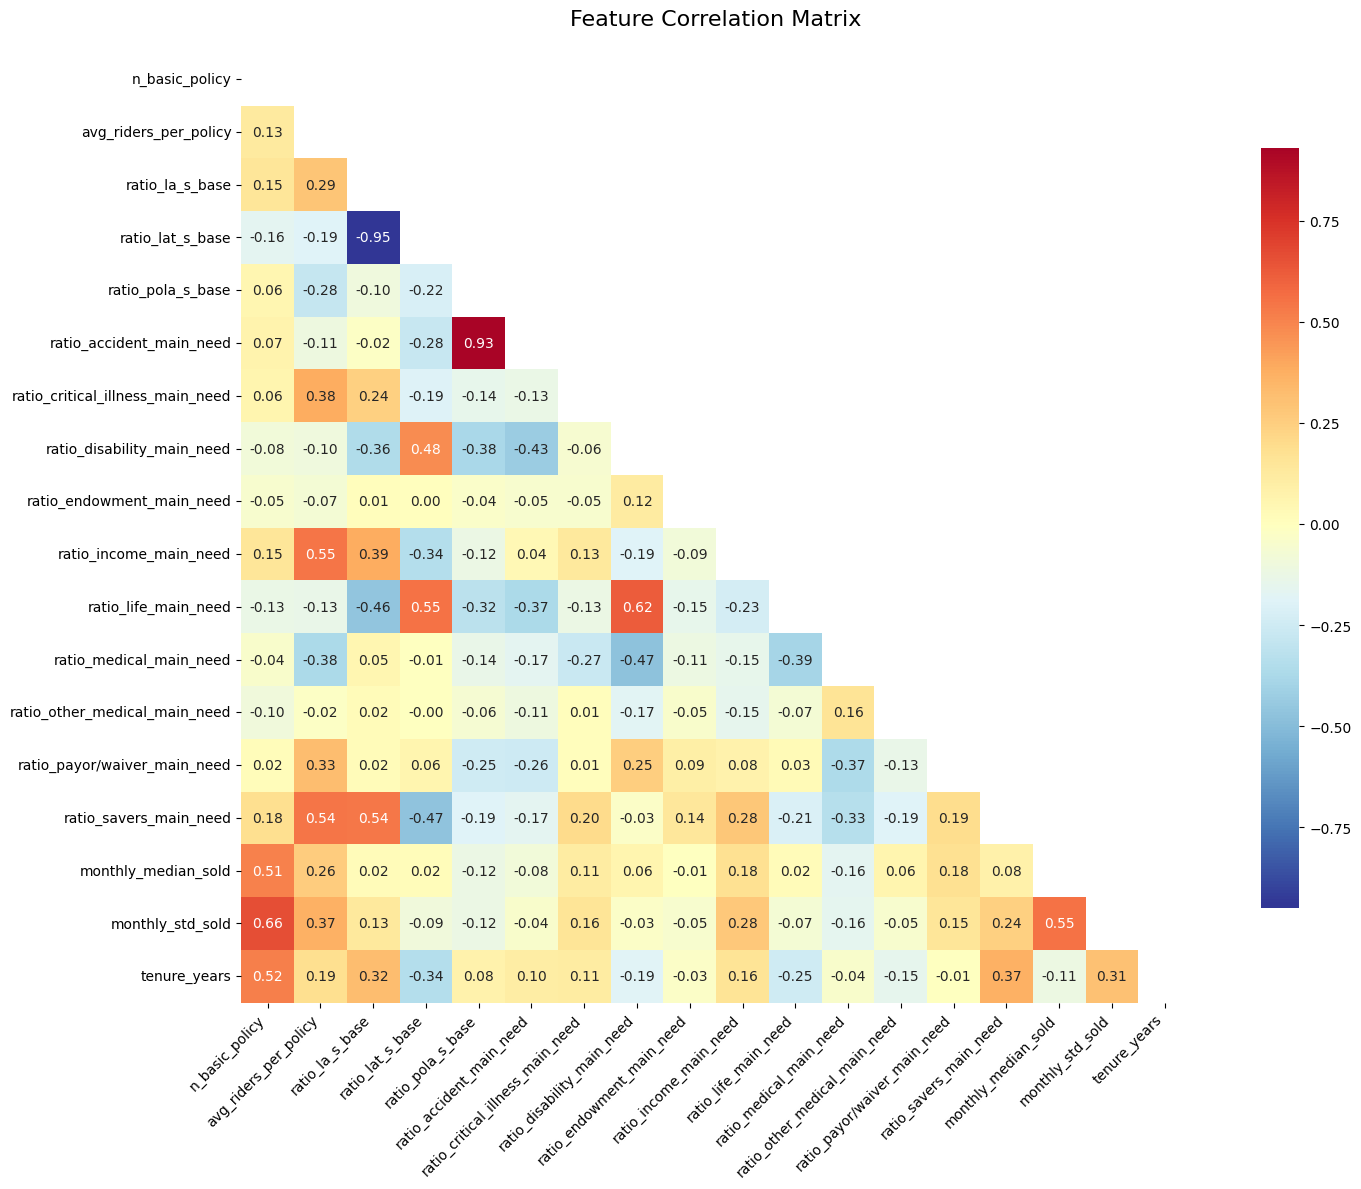

In [73]:
# Calculate correlation matrix
correlation_matrix = scale_df_train.corr()

# Create the heatmap
plt.figure(figsize=(16, 12))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Feature Correlation Matrix.png', dpi=300)
plt.show()


The concerning correlation if we set the threshold of 0.9 is  between 
1. ACCIDENT and POLA, this is due to POLA are only accident, but doesnt mean its accident it will into POLA
2. LA and LAT is due to whether the customer will chosee LA or Takaful

Thus we are not removing either of the columns

## Model Preparation & Fine Tuning

In [51]:
# Range of cluster numbers to test
k_range = range(2, 15 + 1)
inertias = []
silhouette_scores = []

for k in k_range:
   print(f"Testing Model with {k} Cluster is being processed", end='')
   
   # Fit KMeans
   kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
   kmeans.fit(scale_df_train)
   
   # Store inertia (within-cluster sum of squares)
   inertias.append(kmeans.inertia_)
   
   # Calculate silhouette score
   silhouette_avg = silhouette_score(scale_df_train, kmeans.labels_)
   silhouette_scores.append(silhouette_avg)
   
   print(f" Inertia: {kmeans.inertia_:.0f}, Silhouette: {silhouette_avg:.3f}")

Testing Model with 2 Cluster is being processed Inertia: 47962, Silhouette: 0.215
Testing Model with 3 Cluster is being processed Inertia: 41293, Silhouette: 0.243
Testing Model with 4 Cluster is being processed Inertia: 36650, Silhouette: 0.262
Testing Model with 5 Cluster is being processed Inertia: 33687, Silhouette: 0.229
Testing Model with 6 Cluster is being processed Inertia: 31608, Silhouette: 0.238
Testing Model with 7 Cluster is being processed Inertia: 29728, Silhouette: 0.189
Testing Model with 8 Cluster is being processed Inertia: 28032, Silhouette: 0.176
Testing Model with 9 Cluster is being processed Inertia: 26826, Silhouette: 0.184
Testing Model with 10 Cluster is being processed Inertia: 25590, Silhouette: 0.180
Testing Model with 11 Cluster is being processed Inertia: 24463, Silhouette: 0.181
Testing Model with 12 Cluster is being processed Inertia: 23480, Silhouette: 0.184
Testing Model with 13 Cluster is being processed Inertia: 22662, Silhouette: 0.181
Testing Mode

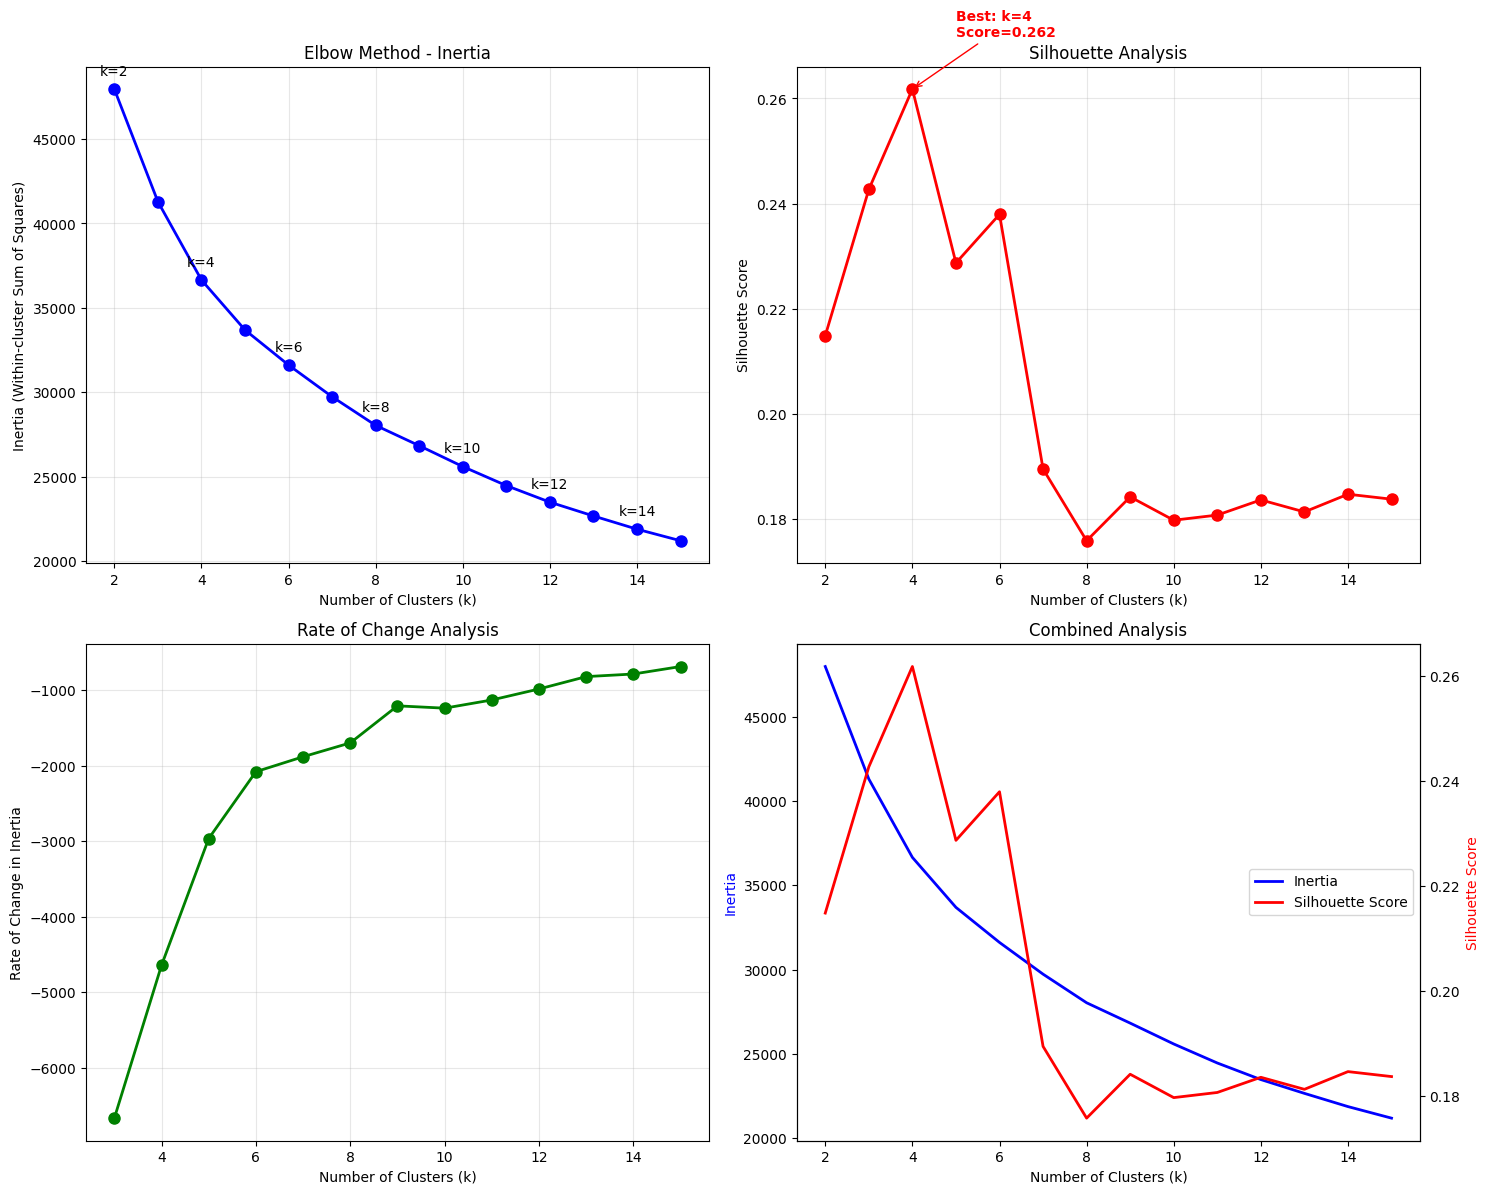

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Elbow Curve (Inertia)
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[0, 0].set_title('Elbow Method - Inertia')
axes[0, 0].grid(True, alpha=0.3)

# Add annotations for potential elbow points
for i, (k, inertia) in enumerate(zip(k_range, inertias)):
    if i % 2 == 0:  # Annotate every other point to avoid crowding
        axes[0, 0].annotate(f'k={k}', (k, inertia), 
                            textcoords="offset points", xytext=(0,10), ha='center')

# 2. Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Analysis')
axes[0, 1].grid(True, alpha=0.3)

best_silhouette_k = k_range[np.argmax(silhouette_scores)]
best_silhouette_score = max(silhouette_scores)
axes[0, 1].annotate(f'Best: k={best_silhouette_k}\nScore={best_silhouette_score:.3f}', 
                    xy=(best_silhouette_k, best_silhouette_score),
                    xytext=(best_silhouette_k+1, best_silhouette_score+0.01),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontweight='bold', color='red')

rate_of_change = np.diff(inertias)
axes[1, 0].plot(k_range[1:], rate_of_change, 'go-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Rate of Change in Inertia')
axes[1, 0].set_title('Rate of Change Analysis')
axes[1, 0].grid(True, alpha=0.3)

# 4. Combined Analysis
ax1 = axes[1, 1]
ax2 = ax1.twinx()
    
line1 = ax1.plot(k_range, inertias, 'b-', linewidth=2, label='Inertia')
line2 = ax2.plot(k_range, silhouette_scores, 'r-', linewidth=2, label='Silhouette Score')

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='blue')
ax2.set_ylabel('Silhouette Score', color='red')
ax1.set_title('Combined Analysis')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.savefig('Model FineTuning And Evaluations.png', dpi=300)
plt.show()

rate_of_change = np.abs(np.diff(inertias))
second_derivative = np.diff(rate_of_change)

# Potential elbow points (where rate of change decreases significantly)
elbow_candidates = []
for i in range(1, len(second_derivative)):
    if second_derivative[i] > 0 and second_derivative[i-1] < 0:
        elbow_candidates.append(k_range[i+1])


In [53]:
rate_of_change

array([6668.97527073, 4643.51185974, 2963.43780104, 2078.0464669 ,
       1880.15444118, 1696.33834689, 1205.5070282 , 1236.33270589,
       1127.59662773,  982.02945135,  818.0951676 ,  783.71415309,
        684.48258549])

In [54]:
second_derivative

array([-2025.46341099, -1680.0740587 ,  -885.39133414,  -197.89202571,
        -183.81609429,  -490.83131869,    30.82567769,  -108.73607816,
        -145.56717639,  -163.93428374,   -34.38101451,   -99.2315676 ])

By looking the elbow method and Silhouette Score, Cluster 4 is recommended.
1. The rate of change from cluster 4 to 5 are not the same as from 2 to 3 to 4
2. Silhouette Score for cluster 4 is the nearest

In [55]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=100)
model = kmeans.fit(scale_df_train)
results = model.predict(scale_df_train[model.feature_names_in_])
df_train['cluster'] = results

In [56]:
import pickle as pkl
with open('model.pkl', 'wb') as f:
    pkl.dump(model, f)

In [57]:
df_train['cluster'].value_counts()

cluster
2    1728
0    1168
3     261
1      74
Name: count, dtype: int64

In [58]:
df_train.to_parquet('df_train.parquet',index=False,engine='pyarrow')

## Cluster Interpretation

Since I am insufficient of time, I will use the description of the data for each Cluster. I should do more detailed analysis and graph to justify my reasoning.

In [59]:
df_train[df_train['cluster']==0].describe()

,agt_cd,n_basic_policy,avg_riders_per_policy,ratio_la_s_base,ratio_lat_s_base,ratio_pola_s_base,ratio_accident_main_need,ratio_critical_illness_main_need,ratio_disability_main_need,ratio_endowment_main_need,ratio_income_main_need,ratio_life_main_need,ratio_medical_main_need,ratio_other_medical_main_need,ratio_payor/waiver_main_need,ratio_savers_main_need,monthly_median_sold,monthly_std_sold,tenure_years,cluster
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.0
mean,2330.457192,27.931507,3.316504,0.063663,0.935607,0.000730,0.017538,0.060286,0.222077,0.007673,0.011217,0.304102,0.169961,0.019031,0.108217,0.079899,7.885702,6.961414,0.843532,0.0
std,1386.448196,31.717456,1.404205,0.195247,0.195912,0.008030,0.037707,0.063401,0.075594,0.026428,0.021252,0.116485,0.109220,0.035250,0.080346,0.061900,8.518793,6.295121,0.780861,0.0
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1146.500000,5.000000,2.331081,0.000000,1.000000,0.000000,0.000000,0.000000,0.175991,0.000000,0.000000,0.250000,0.101316,0.000000,0.045455,0.014935,3.000000,2.279750,0.119781,0.0
50%,2263.500000,17.000000,3.200000,0.000000,1.000000,0.000000,0.000000,0.045663,0.210835,0.000000,0.000000,0.285714,0.166667,0.000000,0.106172,0.085914,6.000000,6.009500,0.557153,0.0
75%,3498.000000,39.250000,4.162634,0.000000,1.000000,0.000000,0.016737,0.096819,0.250000,0.000000,0.013986,0.333333,0.234423,0.021053,0.156686,0.121266,10.500000,10.068250,1.640657,0.0
max,4804.000000,198.000000,10.000000,1.000000,1.000000,0.166667,0.500000,0.500000,0.500000,0.250000,0.142857,1.000000,0.571429,0.200000,0.333333,0.341880,126.000000,68.505000,3.055441,0.0


Cluster 0 (Takaful Player) - Where Agent Focus in LA Takaful Portfolio , Majorly policies involved Disability , Life and Medical

In [60]:
df_train[df_train['cluster']==1].describe()

,agt_cd,n_basic_policy,avg_riders_per_policy,ratio_la_s_base,ratio_lat_s_base,ratio_pola_s_base,ratio_accident_main_need,ratio_critical_illness_main_need,ratio_disability_main_need,ratio_endowment_main_need,ratio_income_main_need,ratio_life_main_need,ratio_medical_main_need,ratio_other_medical_main_need,ratio_payor/waiver_main_need,ratio_savers_main_need,monthly_median_sold,monthly_std_sold,tenure_years,cluster
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.0
mean,2356.878378,24.216216,0.622121,0.095314,0.000964,0.903722,0.904232,0.009649,0.008318,0.001592,0.001371,0.016586,0.040644,0.001665,0.006432,0.009511,1.054054,1.619230,1.090553,1.0
std,1438.892820,40.557171,1.237847,0.156847,0.005190,0.158053,0.157192,0.041322,0.019627,0.006427,0.005800,0.047229,0.082144,0.006911,0.018222,0.022870,1.270227,2.402446,0.826313,0.0
min,118.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1179.500000,2.000000,0.000000,0.000000,0.000000,0.775284,0.775284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393000,0.112252,1.0
50%,2271.000000,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.098000,1.382615,1.0
75%,3352.500000,29.750000,1.000000,0.216427,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025862,0.000000,0.000000,0.000000,1.000000,2.139250,1.859001,1.0
max,4807.000000,259.000000,6.000000,0.500000,0.032258,1.000000,1.000000,0.333333,0.080000,0.032258,0.037736,0.250000,0.294643,0.035088,0.114286,0.090909,6.000000,18.078000,2.138261,1.0


Cluster 1 (Accident Insurer) - Agent Who Main Focus is using POLA Portfolio , Majorly involved Accident Policy

In [61]:
df_train[df_train['cluster']==2].describe()

,agt_cd,n_basic_policy,avg_riders_per_policy,ratio_la_s_base,ratio_lat_s_base,ratio_pola_s_base,ratio_accident_main_need,ratio_critical_illness_main_need,ratio_disability_main_need,ratio_endowment_main_need,ratio_income_main_need,ratio_life_main_need,ratio_medical_main_need,ratio_other_medical_main_need,ratio_payor/waiver_main_need,ratio_savers_main_need,monthly_median_sold,monthly_std_sold,tenure_years,cluster
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.0
mean,2344.765625,49.335648,4.422932,0.936687,0.030101,0.033212,0.074549,0.100049,0.150770,0.009226,0.041783,0.149997,0.170253,0.014559,0.111144,0.177669,8.810764,9.835492,1.558922,2.0
std,1394.786805,52.973064,1.313360,0.124296,0.106011,0.069744,0.086855,0.063371,0.039542,0.029811,0.038487,0.045026,0.082415,0.022434,0.048662,0.055742,10.151277,7.575747,0.895417,0.0
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,1085.000000,15.000000,3.525419,0.923810,0.000000,0.000000,0.000000,0.066276,0.126437,0.000000,0.000000,0.123039,0.115385,0.000000,0.083333,0.143905,2.000000,5.241250,1.026694,2.0
50%,2315.500000,34.000000,4.301515,1.000000,0.000000,0.000000,0.044944,0.100000,0.145455,0.000000,0.035750,0.144578,0.153624,0.005682,0.114373,0.176471,6.500000,8.358000,1.916496,2.0
75%,3598.250000,66.000000,5.166667,1.000000,0.000000,0.035336,0.121081,0.129649,0.169118,0.008111,0.073171,0.171429,0.211026,0.019231,0.142857,0.210039,11.500000,12.504750,2.078029,2.0
max,4785.000000,492.000000,11.000000,1.000000,1.000000,0.529412,0.571429,1.000000,0.400000,0.750000,0.166667,0.500000,0.515539,0.142857,0.291667,0.500000,107.500000,93.366000,11.493498,2.0


In [67]:
df['MAIN_NEED'].value_counts(normalize=True)

MAIN_NEED
Medical             0.181644
Life                0.176893
Disability          0.158018
Savers              0.156094
Payor/Waiver        0.108794
Critical Illness    0.088814
Accident            0.070603
Income              0.038233
Other Medical       0.014510
Endowment           0.006395
Name: proportion, dtype: float64

Cluster 2 (Experienced Life Player) - Agent Who Main Focus is LA Portfolio, and the Policy is well distributed across all needs following the overall MAIN_NEED distributions.

In [62]:
df_train[df_train['cluster']==3].describe()

,agt_cd,n_basic_policy,avg_riders_per_policy,ratio_la_s_base,ratio_lat_s_base,ratio_pola_s_base,ratio_accident_main_need,ratio_critical_illness_main_need,ratio_disability_main_need,ratio_endowment_main_need,ratio_income_main_need,ratio_life_main_need,ratio_medical_main_need,ratio_other_medical_main_need,ratio_payor/waiver_main_need,ratio_savers_main_need,monthly_median_sold,monthly_std_sold,tenure_years,cluster
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.0
mean,2626.666667,20.655172,1.490041,0.725352,0.232806,0.041842,0.050059,0.024018,0.057437,0.004350,0.006138,0.062577,0.673704,0.055981,0.026713,0.039023,2.603448,3.100130,0.946520,3.0
std,1410.939033,28.470563,0.897744,0.368070,0.377201,0.100732,0.103172,0.042510,0.058816,0.023060,0.016350,0.065211,0.246567,0.092300,0.038165,0.053239,3.531837,3.318739,0.857728,0.0
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,1407.000000,2.000000,1.000000,0.563380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.472727,0.000000,0.000000,0.000000,1.000000,0.000000,0.041068,3.0
50%,2656.000000,9.000000,1.695652,0.948276,0.000000,0.000000,0.000000,0.000000,0.056604,0.000000,0.000000,0.058824,0.641667,0.012346,0.000000,0.000000,2.000000,2.614000,0.698152,3.0
75%,3912.000000,28.000000,2.083333,1.000000,0.368421,0.000000,0.041985,0.042857,0.100000,0.000000,0.000000,0.111111,1.000000,0.067308,0.052632,0.072519,3.000000,4.272000,1.859001,3.0
max,4810.000000,262.000000,3.600000,1.000000,1.000000,0.500000,0.500000,0.500000,0.291667,0.333333,0.095890,0.333333,1.000000,0.500000,0.166667,0.333333,34.000000,16.870000,2.401095,3.0


Cluster 3 (New Agents) - Early Agents who mainly focus on Client who seek Medical Insurance